# Dissected Feature Selection - Random Forest

**Feature selection using Recursive Feature Elimination**: the idea is to fit the model, then remove the less relevant feature and calculate the average value of some performance metric in CV. Then we remove the second last important feature, fit the model again and calculate the average performance. We keep doing this approach until there are no features left. The set of features that maximize the performance in CV is the set of features we have to work with.

## Libraries and Configurations

Import configuration files

In [1]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [2]:
import pandas as pd

Import **ML libraries**

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

Import **other libraries**

In [4]:
from rich.progress import Progress
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7b0d7bb50f50>>

In [5]:
import numpy as np
import matplotlib.pyplot as plt

Custom helper scripts

In [6]:
%cd ..
from scripts import plotHelper, encodingHelper
%cd data_exploration_cleaning

/home/bacci/COMPACT/notebooks
/home/bacci/COMPACT/notebooks/data_exploration_cleaning


In [7]:
reports_path = config["DEFAULT"]["reports_path"]

## Dissected Data

In [8]:
dissected_df_raw_csv = (
    config["DEFAULT"]["interim_path"] + "dissected/std_dissected_df_raw.csv"
)

In [9]:
df = pd.read_csv(dissected_df_raw_csv, index_col=0)

In [10]:
df

,MAC Address,Channel,DS Channel,Vendor Specific Tags,Length,Label,Supported Rates 1,Supported Rates 2,Supported Rates 3,Supported Rates 4,...,TIM_Broadcast,BSS_Transition,Multiple_BSSID,Timing_Measurement,SSID_List,DMS,Interworking,QoS_Map,WNM_Notification,Operating_Mode_Notification
0,1a:e6:5a:fe:34:4c,1,1.0,NaN,111,iPhone7_F,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1a:e6:5a:fe:34:4c,1,1.0,NaN,111,iPhone7_F,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,1a:e6:5a:fe:34:4c,11,1.0,NaN,111,iPhone7_F,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1a:e6:5a:fe:34:4c,1,2.0,NaN,111,iPhone7_F,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,1a:e6:5a:fe:34:4c,11,2.0,NaN,111,iPhone7_F,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13939,da:a1:19:00:17:f9,6,1.0,0050f208002400,182,XiaomiRedmiNote7_S,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
13940,da:a1:19:1a:cc:8f,6,8.0,0050f208002400,182,XiaomiRedmiNote7_S,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
13941,da:a1:19:41:c9:b1,11,5.0,0050f208002400,143,XiaomiRedmiNote7_S,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
13942,da:a1:19:c7:24:b1,1,3.0,0050f208002400,182,XiaomiRedmiNote7_S,1.0,2.0,5.5,11.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [11]:
to_drop = ["MAC Address"]
df = df.drop(to_drop, axis=1)

### Label Encode Categorical Features

Features like `Vendor Specific Tags` are not included in the IEEE 802.11 standard, rendering them incomparable across various vendors. Consequently, we must regard such features as categorical, rendering the application of the concept of distance meaningless in this context.

In [12]:
# Import label encoder
from sklearn import preprocessing

In [13]:
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df["Vendor Specific Tags"] = label_encoder.fit_transform(df["Vendor Specific Tags"])

In [14]:
df

,Channel,DS Channel,Vendor Specific Tags,Length,Label,Supported Rates 1,Supported Rates 2,Supported Rates 3,Supported Rates 4,Extended Supported Rates 1,...,TIM_Broadcast,BSS_Transition,Multiple_BSSID,Timing_Measurement,SSID_List,DMS,Interworking,QoS_Map,WNM_Notification,Operating_Mode_Notification
0,1,1.0,62,111,iPhone7_F,1.0,2.0,5.5,11.0,6.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1,1.0,62,111,iPhone7_F,1.0,2.0,5.5,11.0,6.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
2,11,1.0,62,111,iPhone7_F,1.0,2.0,5.5,11.0,6.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,1,2.0,62,111,iPhone7_F,1.0,2.0,5.5,11.0,6.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,11,2.0,62,111,iPhone7_F,1.0,2.0,5.5,11.0,6.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13939,6,1.0,25,182,XiaomiRedmiNote7_S,1.0,2.0,5.5,11.0,6.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
13940,6,8.0,25,182,XiaomiRedmiNote7_S,1.0,2.0,5.5,11.0,6.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
13941,11,5.0,25,143,XiaomiRedmiNote7_S,1.0,2.0,5.5,11.0,6.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
13942,1,3.0,25,182,XiaomiRedmiNote7_S,1.0,2.0,5.5,11.0,6.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


### Dealing w/ `NaN`

In [15]:
df.fillna("-1", inplace=True)

/tmp/ipykernel_23607/4038702002.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("-1", inplace=True)


### Split Dataframe

In [16]:
X = df.drop(columns=["Label"])
y = df["Label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.4, random_state=42, stratify=y
)

### Normalize Data

In [17]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

### Random Forest

In [18]:
sel = SelectFromModel(RandomForestClassifier(n_estimators=100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [19]:
selected_feat = X_train.columns[(sel.get_support())]
len(selected_feat)

15

In [20]:
print(selected_feat)

Index(['Vendor Specific Tags', 'Length', 'DSSS_CCK', 'SM_Power_Save',
       'Min_MPDCU_Start_Spacing', 'RX_Highest_Supported_Data_Rate',
       'RX_MSC_Bitmask', 'Extended_Channel_Switching', 'WNM_Sleep_Mode',
       'SSID_List', 'DMS', 'Interworking', 'QoS_Map', 'WNM_Notification',
       'Operating_Mode_Notification'],
      dtype='object')


In [21]:
feature_importances = pd.Series(
    sel.estimator_.feature_importances_.ravel(), index=X_train.columns
)

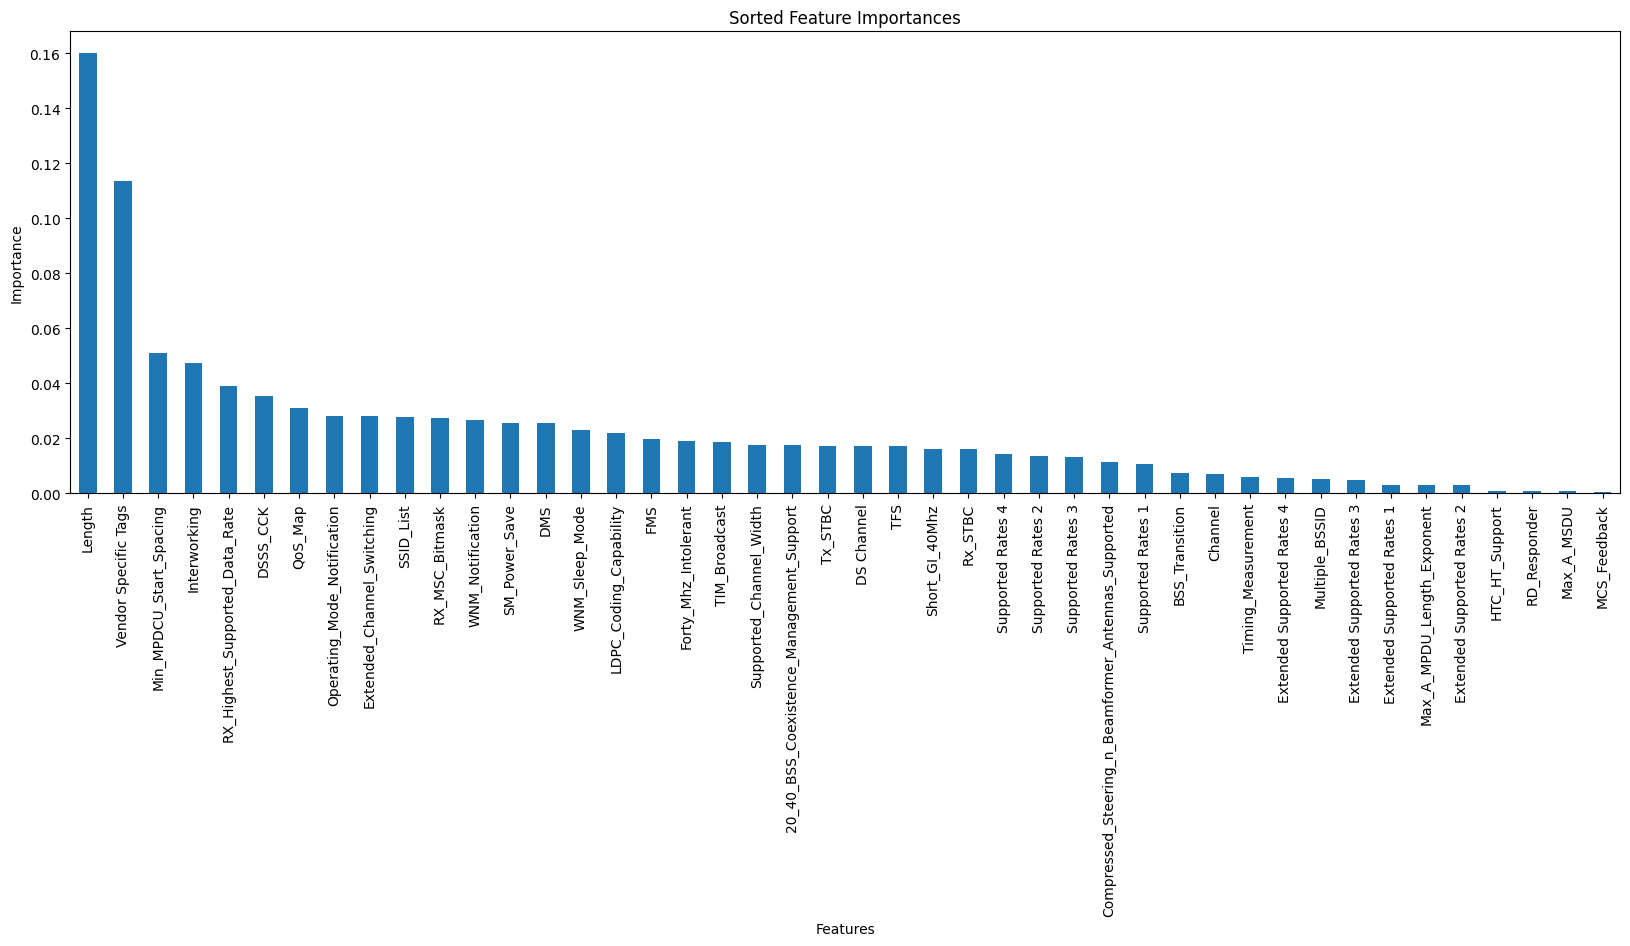

In [27]:
sorted_importances = feature_importances.sort_values(ascending=False)
plt.figure(figsize=(20, 6))  # Set the size of the figure

sorted_importances.plot(kind="bar")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Sorted Feature Importances")
plt.show()

Saving feature importance to file

In [24]:
importances_df = pd.DataFrame(
    {"Feature": feature_importances.index, "Importance": feature_importances.values}
)
importances_df.to_csv(
    reports_path + "/CSV/feature_selection/DISSECTED_importances_RF.csv", index=False
)

## Feature Correlation

Let's check the correlation between the original features

In [32]:
import seaborn as sns

In [33]:
corr = df.drop(columns=["Label"]).corr()

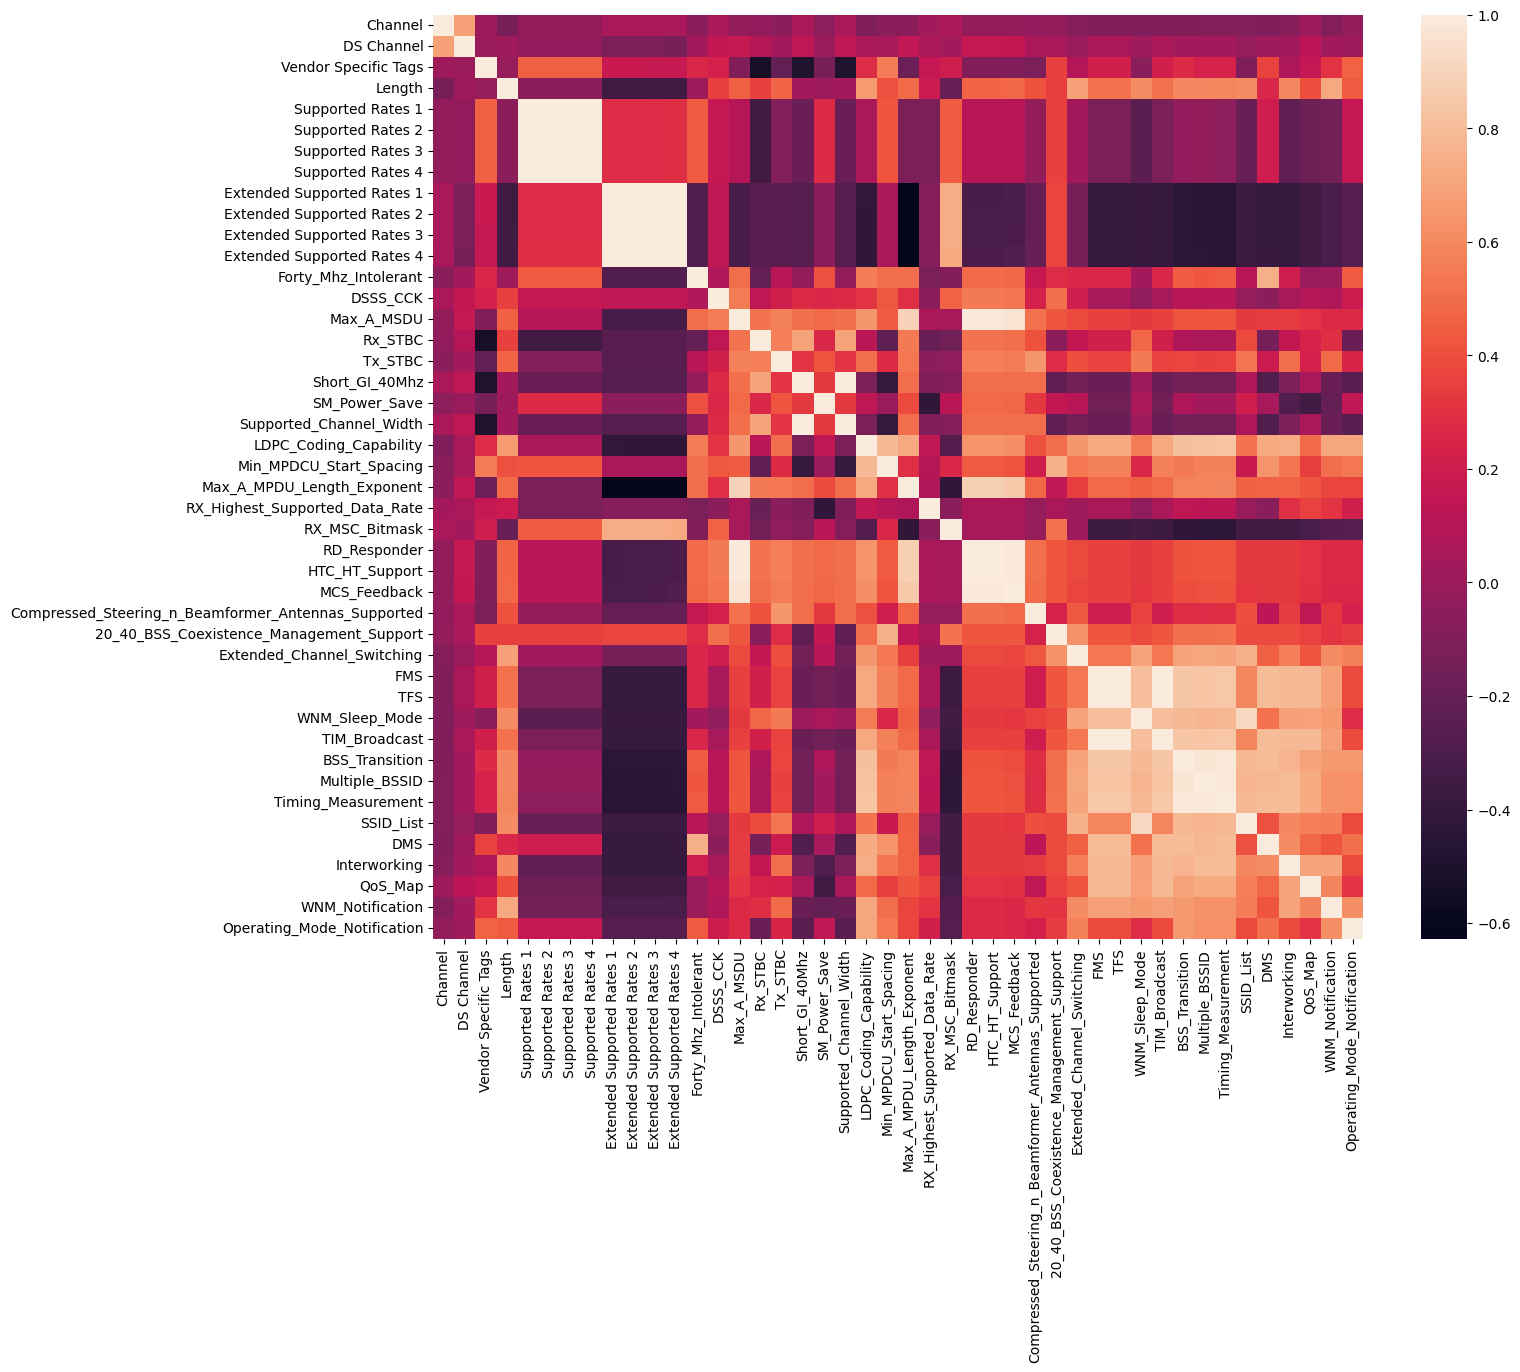

In [36]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr)

plt.savefig(
    reports_path + "figures/feature_selection/std_feature_correlation.png", dpi=300
)

plt.show()